In [7]:
import glob
from os.path import join as oj

import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from typing import Dict
import functools
import seaborn as sns
import matplotlib.pyplot as plt

import rulevetting
from rulevetting.api import validation, util as api_util
from rulevetting.projects.csi_pecarn.dataset1 import Dataset
from rulevetting import DATA_PATH


In [8]:
raw_data_path = oj(rulevetting.DATA_PATH, Dataset().get_dataset_id(), 'raw')
fnames = sorted(glob.glob(f'{raw_data_path}/*'))
dfs = [pd.read_csv(fname) for fname in fnames]
dfs[0].loc[:, 'ControlType'] = (dfs[0]['ControlType'] == 'case').astype(int)
# fname=glob.glob(f'{raw_data_path}/clinicalpresentationsite.csv')[0]
# dfs = pd.read_csv(fname)
# dfs = dfs.replace(['Y', 'YES', 'A'], 1)       
# dfs = dfs.replace(['N', 'NO'], 0)
# dfs = dfs.replace(['ND', 'NA'], float("NaN"))
# dfs=dfs.fillna(dfs.median()) 

# Correlation of features and in groups and association with outcome


## Group1: Consciousness

In [90]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<AxesSubplot:>

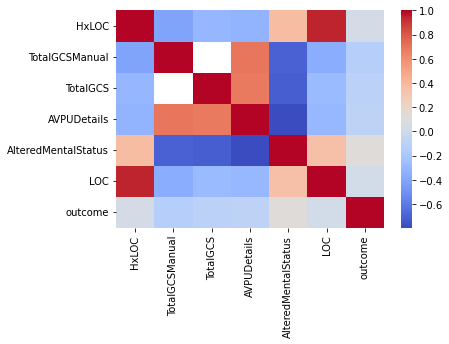

In [115]:
feat_conscious = ['HxLOC', 'TotalGCSManual', 'TotalGCS', 'AVPUDetails','AlteredMentalStatus', 'LOC','ControlType_x']
dfs_conscious=dfs[0].merge(dfs[3],how='left', on=['SITE', 'CaseID', 'StudySubjectID'])
dfs_conscious=dfs_conscious[feat_conscious]
# dfs_conscious.loc[:, 'ControlType_x'] = (dfs_conscious['ControlType_x'] == 'case').astype(int)

dfs_conscious = dfs_conscious.replace(['Y', 'YES', 'A'], 1)       
dfs_conscious = dfs_conscious.replace(['N', 'NO'], 0)
dfs_conscious = dfs_conscious.replace(['15'], 15)
dfs_conscious = dfs_conscious.replace(['10'], 10)
dfs_conscious = dfs_conscious.replace(['14'], 14)
dfs_conscious = dfs_conscious.replace(['6'], 6)
dfs_conscious = dfs_conscious.replace(['8'], 8)
dfs_conscious = dfs_conscious.replace(['12'], 12)
dfs_conscious = dfs_conscious.replace(['5'], 5)
dfs_conscious = dfs_conscious.replace(['13'], 13)
dfs_conscious = dfs_conscious.replace(['11'],11)
dfs_conscious = dfs_conscious.replace(['9'], 9)
dfs_conscious = dfs_conscious.replace(['7','7T'], 7)
dfs_conscious = dfs_conscious.replace(['4'], 4)
dfs_conscious = dfs_conscious.replace(['ND', 'NA', '3'], float("NaN"))
dfs_conscious = dfs_conscious.replace(['U','V','N', 'P'], 0)
# dfs_conscious=dfs_conscious.fillna(dfs_conscious.median()) 
# print(dfs_conscious['TotalGCS'])
# print(pd.unique(dfs_conscious['TotalGCS']))
dfs_conscious = dfs_conscious.rename(columns={'ControlType_x': 'outcome'})
dfs_conscious_corr=dfs_conscious.corr(method='pearson')
# .style.background_gradient(cmap="Blues")
sns.heatmap(dfs_conscious_corr,cmap="coolwarm")


## Group2: Complaint of pain in neck and age


<AxesSubplot:>

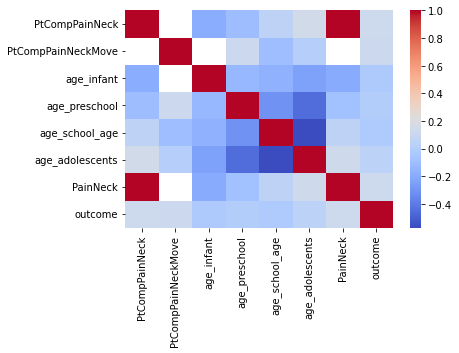

In [116]:
# feat_pain = ['PtCompPainHead', 'PtCompPainFace', 'PtCompPainNeck', 'PtCompPainNeckMove', 'PtCompPainChest', 'PtCompPainBack', 'PtCompPainFlank', 'PtCompPainAbd', 'PtCompPainPelvis', 'PtCompPainExt']
# demog_df = dfs[4]
clean_key_col_names = lambda df: df.rename(columns={'site': 'SITE',
                                                            'caseid': 'CaseID',
                                                            'studysubjectid': 'StudySubjectID'})
demog_df = clean_key_col_names(dfs[4])

agegroup_df = pd.get_dummies(pd.cut(demog_df['AgeInYears'], bins=[0, 2, 6, 12, 16],
                                            labels=['infant', 'preschool', 'school_age', 'adolescents'],
                                            include_lowest=True), prefix='age')
agegroup_df=pd.concat([demog_df[['SITE', 'CaseID', 'StudySubjectID']], agegroup_df], axis=1)

feat_pain = ['PtCompPainNeck', 'PtCompPainNeckMove', 'age_infant', 'age_preschool',  'age_school_age',  'age_adolescents','PainNeck','ControlType_x']
dfs_pain=dfs[0].merge(dfs[3],how='left', on=['SITE', 'CaseID', 'StudySubjectID'])
dfs_pain=dfs_pain.merge(agegroup_df,how='left', on=['SITE', 'CaseID', 'StudySubjectID'])
dfs_pain=dfs_pain[feat_pain]
dfs_pain = dfs_pain.replace(['Y', 'YES', 'A'], 1)       
dfs_pain = dfs_pain.replace(['N', 'NO'], 0)
dfs_pain = dfs_pain.replace(['ND', 'NA'], float("NaN"))
dfs_pain = dfs_pain.rename(columns={'ControlType_x': 'outcome'})
# dfs_pain=dfs_pain.fillna(dfs_pain.median()) 
# print(pd.unique(dfs_pain['PtCompPainNeckMove']))
dfs_pain_corr=dfs_pain.corr(method='pearson')
# .style.background_gradient(cmap="Blues")
sns.heatmap(dfs_pain_corr,cmap="coolwarm")

## Group3: Tenderness in neck


In [26]:
# feat_tender = ['PtTenderHead', 'PtTenderFace', 'PtTenderNeck', 'PtTenderNeckLevel', 'PtTenderNeckLevelC1', 'PtTenderNeckLevelC2', 'PtTenderNeckLevelC3', 'PtTenderNeckLevelC4', 'PtTenderNeckLevelC5', 'PtTenderNeckLevelC6', 'PtTenderNeckLevelC7', 'PtTenderNeckAnt', 'PtTenderNeckPos', 'PtTenderNeckLat', 'PtTenderNeckMid', 'PtTenderNeckOther', 'PtTenderChest', 'PtTenderBack', 'PtTenderFlank', 'PtTenderAbd', 'PtTenderPelvis', 'PtTenderExt']
feat_tender =['PtTenderNeck', 'PtTenderNeckLevel', 'PtTenderNeckLevelC1', 'PtTenderNeckLevelC2', 'PtTenderNeckLevelC3', 'PtTenderNeckLevelC4', 'PtTenderNeckLevelC5', 'PtTenderNeckLevelC6', 'PtTenderNeckLevelC7', 'PtTenderNeckAnt', 'PtTenderNeckPos', 'PtTenderNeckLat', 'PtTenderNeckMid', 'PtTenderNeckOther','PosMidNeckTenderness', 'TenderNeck','ControlType_x'] 

dfs_tender=dfs[0].merge(dfs[3],how='left', on=['SITE', 'CaseID', 'StudySubjectID'])
dfs_tender=dfs_tender[feat_tender]
dfs_tender = dfs_tender.replace(['Y', 'YES', 'A'], 1)       
dfs_tender = dfs_tender.replace(['N', 'NO'], 0)
dfs_tender = dfs_tender.replace(['ND', 'NA'], float("NaN"))
# dfs_tender=dfs_tender.fillna(dfs_tender.median()) 
# print(dfs_tender)
dfs_tender = dfs_tender.rename(columns={'ControlType_x': 'outcome'})
hide_column_neck=["PtTenderNeck", "PtTenderNeckLevel","PtTenderNeckLevelC1","PtTenderNeckLevelC2", "PtTenderNeckLevelC3","PtTenderNeckLevelC4","PtTenderNeckLevelC5","PtTenderNeckLevelC6","PtTenderNeckLevelC7","PtTenderNeckAnt","PtTenderNeckPos","PtTenderNeckLat","PtTenderNeckMid","PtTenderNeckOther","PosMidNeckTenderness","TenderNeck"]
dfs_tender_corr=dfs_tender.corr(method='pearson')
# .style.background_gradient(cmap="Blues").hide_columns(hide_column_neck)
dfs_tender_corr['outcome']

PtTenderNeck            0.040167
PtTenderNeckLevel       0.029306
PtTenderNeckLevelC1     0.030859
PtTenderNeckLevelC2     0.030202
PtTenderNeckLevelC3     0.008022
PtTenderNeckLevelC4     0.013563
PtTenderNeckLevelC5     0.022655
PtTenderNeckLevelC6     0.045919
PtTenderNeckLevelC7     0.065611
PtTenderNeckAnt        -0.018944
PtTenderNeckPos         0.048284
PtTenderNeckLat        -0.017775
PtTenderNeckMid         0.033987
PtTenderNeckOther       0.005980
PosMidNeckTenderness    0.052407
TenderNeck              0.047975
outcome                 1.000000
Name: outcome, dtype: float64

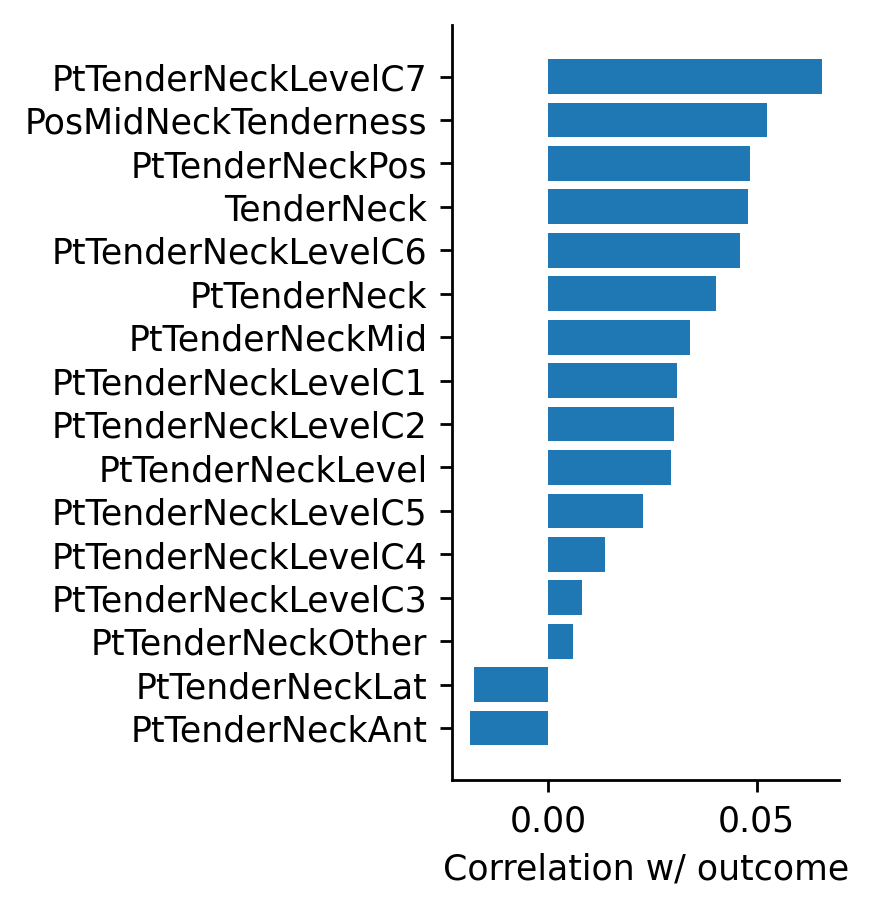

In [75]:
plt.figure(dpi=250, figsize=(2, 4))
vals = dfs_tender_corr['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Group4: Focal neurological deficits

<AxesSubplot:>

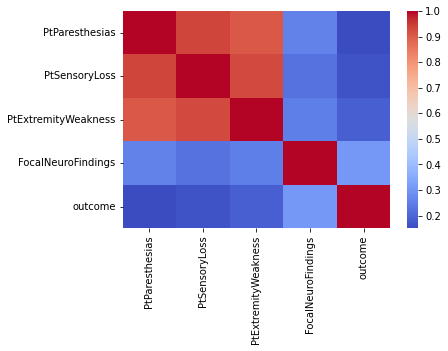

In [117]:
feat_focal= ['PtParesthesias', 'PtSensoryLoss', 'PtExtremityWeakness','FocalNeuroFindings','ControlType_x']
dfs_focal=dfs[0].merge(dfs[3],how='left', on=['SITE', 'CaseID', 'StudySubjectID'])
dfs_focal=dfs_focal[feat_focal]
dfs_focal = dfs_focal.replace(['Y', 'YES', 'A'], 1)       
dfs_focal = dfs_focal.replace(['N', 'NO'], 0)
dfs_focal = dfs_focal.replace(['3'], 3)
dfs_focal = dfs_focal.replace(['ND', 'NA'], float("NaN"))
dfs_focal = dfs_focal.rename(columns={'ControlType_x': 'outcome'})
# dfs_focal=dfs_focal.fillna(dfs_focal.median()) 
# print(pd.unique(dfs_focal['PtExtremityWeakness']))
dfs_focal_corr=dfs_focal.corr(method='pearson')
# .style.background_gradient(cmap="Blues")
sns.heatmap(dfs_focal_corr,cmap="coolwarm")

## Group 5: Other parts of the body

<AxesSubplot:>

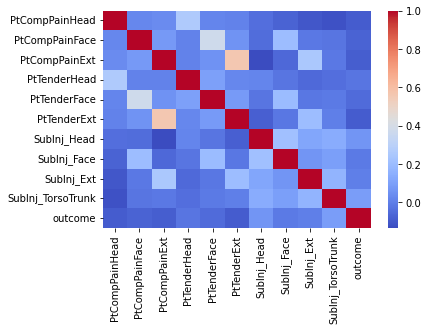

In [118]:
feat_otherpain = ['PtCompPainHead', 'PtCompPainFace', 'PtCompPainExt', 'PtTenderHead', 'PtTenderFace', 'PtTenderExt','SubInj_Head', 'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk','ControlType_x']
dfs_otherpain=dfs[0].merge(dfs[3],how='left', on=['SITE', 'CaseID', 'StudySubjectID'])
dfs_otherpain=dfs_otherpain[feat_otherpain]
dfs_otherpain = dfs_otherpain.replace(['Y', 'YES', 'A'], 1)       
dfs_otherpain = dfs_otherpain.replace(['N', 'NO'], 0)
dfs_otherpain = dfs_otherpain.replace(['ND', 'NA'], float("NaN"))
dfs_otherpain = dfs_otherpain.rename(columns={'ControlType_x': 'outcome'})
# dfs_focal=dfs_focal.fillna(dfs_focal.median()) 
# print(dfs_focal)
dfs_otherpain_corr=dfs_otherpain.corr(method='pearson')
# .style.background_gradient(cmap="Blues")
sns.heatmap(dfs_otherpain_corr,cmap="coolwarm")

## Group6: Injury mechanism


In [86]:
# feat_injury= ['InjuryPrimaryMechanism', 'HeadFirst', 'HeadFirstRegion','HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar', 'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop', 'Clotheslining','ControlType_x']
feat_injury= ['InjuryPrimaryMechanism', 'HeadFirst', 'HeadFirstRegion', 'ControlType_x']
dfs_injury=dfs[0].merge(dfs[6],how='left', on=['SITE', 'CaseID', 'StudySubjectID'])
dfs_injury=dfs_injury[feat_injury]
dfs_injury = dfs_injury.replace(['Y', 'YES', 'A'], 1)       
dfs_injury = dfs_injury.replace(['N', 'NO'], 0)
dfs_injury = dfs_injury.replace(['ND', 'NA'], float("NaN"))
# dfs_injury['InjuryPrimaryMechanism'] = pd.to_numeric(dfs_injury['InjuryPrimaryMechanism'])
# dfs_injury['InjuryPrimaryMechanism'] = dfs_injury['InjuryPrimaryMechanism'].astype('Int64')

series_HeadFirstRegion = pd.get_dummies(dfs_injury.HeadFirstRegion, prefix='HeadFirstRegion')
dfs_injury=dfs_injury.drop(columns=['HeadFirstRegion'])
dfs_injury=pd.concat([series_HeadFirstRegion,dfs_injury], axis=1)

series_injury = pd.get_dummies(dfs_injury.InjuryPrimaryMechanism, prefix='Injuryechanism')
dfs_injury=dfs_injury.drop(columns=['InjuryPrimaryMechanism'])
dfs_injury=pd.concat([series_injury,dfs_injury], axis=1)

dfs_injury=dfs_injury.rename(columns={'Injuryechanism_1': 'Motor Vehicle Collision'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_2': 'outcOther Motorized Transport Crashome'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_3': 'Bike rider struck by moving vehicle'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_4': 'Bike collision or fall from bike'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_5': 'Other non-motorized transport struck by moving vehicle'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_6': 'Pedestrian struck by moving vehicle'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_7': 'Blunt injury to head/neck'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_8': 'Sports injury'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_9': 'Fall from elevation'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_10': 'Fall down stairs'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_11': 'Fall from standing/walking/running'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_12': 'Diving injury'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_13': 'Hanging injury'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_14': 'Other'})
dfs_injury=dfs_injury.rename(columns={'Injuryechanism_20': 'fall from non-motorized transport while riding'})
dfs_injury=dfs_injury.rename(columns={'ControlType_x': 'outcome'})

# dfs_focal=dfs_focal.fillna(dfs_focal.median()) 
# print(pd.unique(dfs_injury['HeadFirstRegion']))
# hide_column_injury=["HeadFirst","HighriskDiving","HighriskFall","HighriskHanging","HighriskHitByCar","HighriskMVC","HighriskOtherMV","AxialLoadAnyDoc","axialloadtop","Clotheslining"]
dfs_injury_corr=dfs_injury.corr(method='pearson')
dfs_injury_corr['outcome']

Motor Vehicle Collision                                   0.011647
Fall down stairs                                         -0.037239
Fall from standing/walking/running                       -0.016366
Diving injury                                             0.202108
Hanging injury                                           -0.017151
Other                                                     0.048613
outcOther Motorized Transport Crashome                    0.005728
fall from non-motorized transport while riding            0.020205
Bike rider struck by moving vehicle                      -0.036586
Bike collision or fall from bike                         -0.014259
Other non-motorized transport struck by moving vehicle   -0.020245
Pedestrian struck by moving vehicle                      -0.044575
Blunt injury to head/neck                                -0.060276
Sports injury                                             0.056625
Fall from elevation                                      -0.02

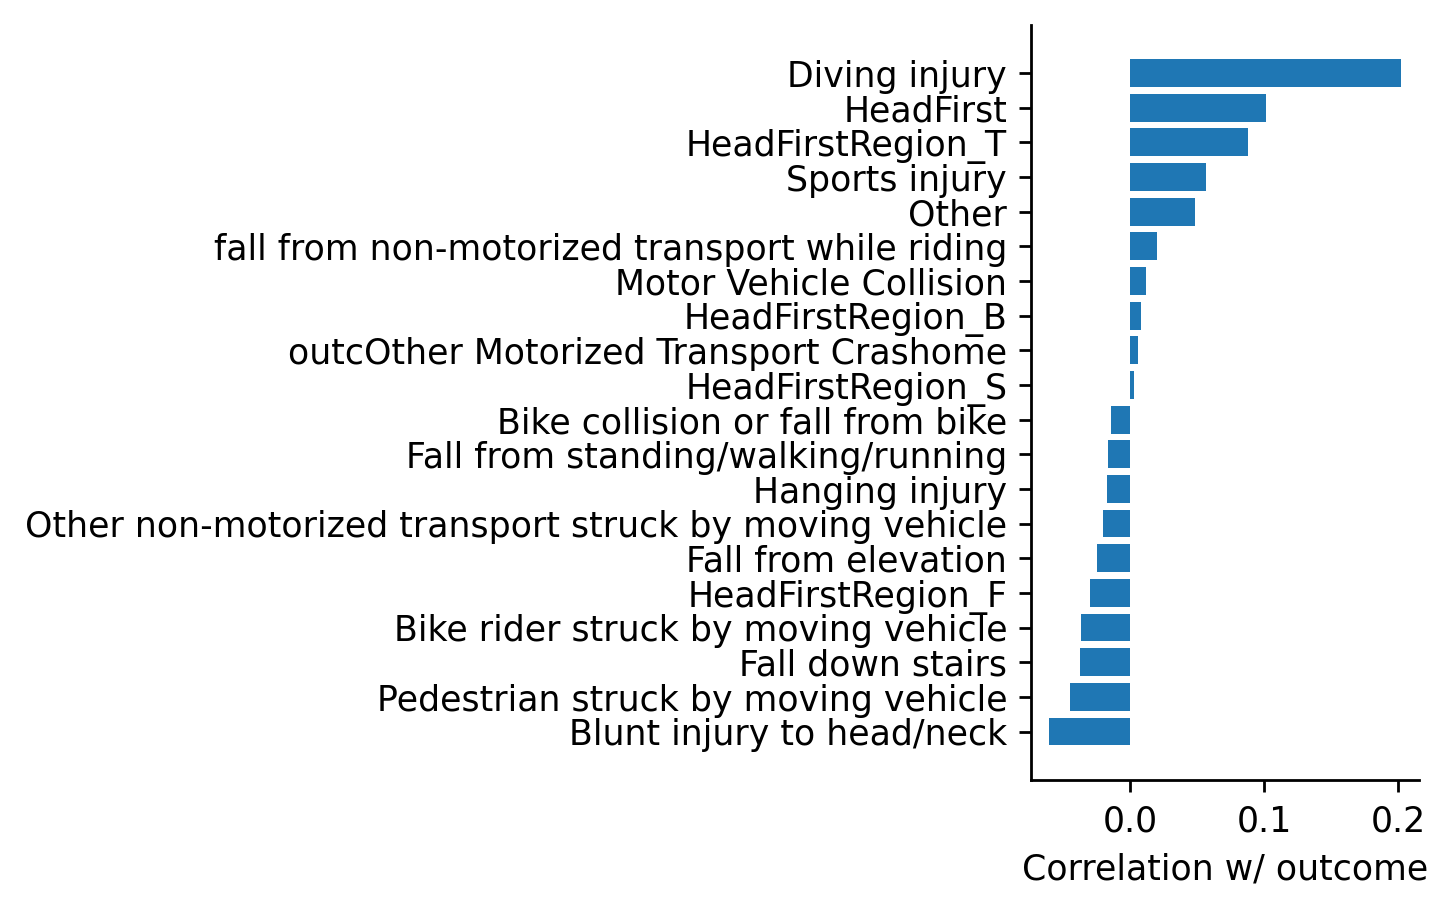

In [88]:
plt.figure(dpi=250, figsize=(2, 4))
vals = dfs_injury_corr['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()